In [201]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import os
from IPython.display import display, Image, Markdown

from functools import partial
from pydantic import BaseModel, Field
from typing import TypedDict, Literal

from langchain_chroma import Chroma
from langchain_core.tools import Tool
from langchain.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.tools import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFaceEndpoint, ChatHuggingFace

from langgraph.graph import START, END, StateGraph

In [203]:
os.environ["TAVILY_API_KEY"] = os.getenv("TavilyApiKey")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [311]:
def CreateDocRetrieverTool(path:str):
    Chroma().delete_collection()
    
    pdf_loader = PyPDFLoader(file_path=path)
    loaded_pdf = pdf_loader.load()
    txt_splitter = RecursiveCharacterTextSplitter(chunk_size=10000, 
                                                  chunk_overlap=100,
                                                  length_function=len)
    
    splitted_doc = txt_splitter.split_documents(loaded_pdf)
    
    embedding = OpenAIEmbeddings()
    
    embedded_doc = Chroma.from_documents(documents=splitted_doc,
                                         embedding=embedding)
    
    doc_retriever = embedded_doc.as_retriever(search_type="mmr", 
                                              search_kwargs={'k': 10, 'fetch_k': 50})
    
    doc_retriever_tool = create_retriever_tool(retriever=doc_retriever, 
                                               name="db_retriever", 
                                               description="This tool contains information from the database.")
    
    return doc_retriever_tool

In [313]:
doc_retriever_tool = CreateDocRetrieverTool("temp.pdf")

In [314]:
def CreateSearchEngineTool(llm, prompt, max_results=10):
    search_tool = TavilySearchResults(max_results=max_results,
                               search_depth="advanced",
                               include_answer=True,
                               handle_tool_error=True,
                               include_raw_content=True,
                               include_images=False)

    agent_with_tools = create_tool_calling_agent(llm=llm, tools=[search_tool], prompt=prompt)

    agent_executor = AgentExecutor(agent=agent_with_tools, 
                          tools=[search_tool],
                          verbose=False,
                          handle_parsing_errors=True)
    
    return agent_executor

In [315]:
llm = ChatOpenAI()

In [316]:
class AgentSchema(TypedDict):
    input_message:str
    search_result:str
    query_output:str

In [317]:
class ModelRouter(BaseModel):
    """
    Route a user query to the appropriate tool. 
    """
    route: Literal["websearch", "db_retriever"] = Field(
        ..., 
        description="Specifies the routing choice for processing user queries. "
                    "'websearch' directs the query to an online search engine, "
                    "while 'db_retriever' fetches relevant information from a database."
    )

In [318]:
def DecideRoute(state: AgentSchema):
    model_with_structured_output = llm.with_structured_output(ModelRouter)

    prompt = ChatPromptTemplate.from_messages([
        ("system", ("You are an expert in routing users query to either websearch or database retriever."
                    "The database retriever contains information about the reseach paper titled 'Attention is all you need'."
                    "Use the database retriever for queries related to the research paper. Otherwise, use websearch."
                   )
        ),
        ("user", "{user_input}")
    ])

    llm_chain = prompt | model_with_structured_output

    data_source = llm_chain.invoke({"user_input":state['input_message']})

    print("Source:", data_source)
    
    if data_source.route == "db_retriever":
        return "db_retriever"
    else:
        return "websearch"

In [319]:
# DecideRoute(state={"input_message":"Current president of the united states?"})

In [320]:
def DB_Search(state: AgentSchema):
    query_prompt = ChatPromptTemplate.from_messages([
        ("system", ("You are an expert in querying a database retriever system. "
                    "Always assume that every user question requires retrieval from the database. "
                    "Rephrase the input only if necessary to optimize it for retrieval while preserving its intent. "
                    "If the input is already optimized or unclear, return it exactly as it is without modification.")
        ),
        ("user", "{user_input}")
    ])

    query_chain = query_prompt | llm

    optimized_query = query_chain.invoke(state["input_message"]).content

    query_output = doc_retriever_tool.invoke(optimized_query)

    information_extraction_prompt = ChatPromptTemplate.from_messages([
        ("system",("You are an intelligent assistant that answers questions naturally, based on the given information. "
                   "Your responses should feel like a knowledgeable human, without unnecessary introductions or formal structuring.\n\n"
                   "Context:\n{context}")
    ),
        ("user", "{user_input}")
    ])

    infor_ext_chain = information_extraction_prompt | llm
    
    return {"search_result": infor_ext_chain.invoke({"user_input":query_output, "context":optimized_query}).content}

In [321]:
def InternetSearch(state: AgentSchema):
    query_prompt = ChatPromptTemplate.from_messages([
        ("system", 
            "Rephrase user input into a concise, well-structured Google search query. "
            "Keep it clear, relevant, and keyword-optimized. "
            "If already well-formed, return as is."
        ),
        ("user", "{user_input}")
    ])

    query_chain = query_prompt | llm
    
    optimized_query = query_chain.invoke({"user_input":state["input_message"]}).content

    search_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert search assistant. Your goal is to retrieve the most relevant information."),
        MessagesPlaceholder(variable_name="chat_history", optional=True),
        ("user", "{search_query}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])

    search_tool = CreateSearchEngineTool(llm=llm, prompt=search_prompt)

    return {"search_result":search_tool.invoke({"search_query":optimized_query})["output"]}

In [322]:
# InternetSearch(state={"input_message":"who is the current president of AMERICA"})

In [323]:
def FineTuneResponse(state: AgentSchema):
    prompt = ChatPromptTemplate.from_messages([
                    ("system", "You are a helpful assistant that extracts the main answer from search results while removing unnecessary phrases."),
                    ("user", "Given the following search result, extract and provide only the main answer:\n\n{search_results}")
                ])
    finetune_chain = prompt | llm

    results = finetune_chain.invoke({"search_results":state["search_result"]}).content

    return {"query_output":results}

In [324]:
# FineTuneResponse(state={"search_result":" Based on your search query, the president of Nigeria is Tunubu"})

In [325]:
bot_workflow = StateGraph(state_schema=AgentSchema)

In [326]:
bot_workflow.add_node("DB_Search", DB_Search)
bot_workflow.add_node("InternetSearch", InternetSearch)
bot_workflow.add_node("FineTuneResponse", FineTuneResponse)

In [327]:
bot_workflow.add_conditional_edges(START, 
                                   DecideRoute, 
                                   {"db_retriever":"DB_Search",
                                    "websearch":"InternetSearch"})

bot_workflow.add_edge("DB_Search", "FineTuneResponse")
bot_workflow.add_edge("InternetSearch", "FineTuneResponse")
bot_workflow.add_edge("FineTuneResponse", END)

In [328]:
multi_agent_bot = bot_workflow.compile()

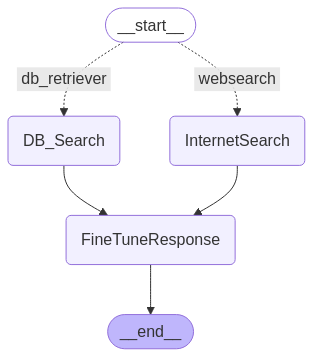

In [331]:
display(Image(multi_agent_bot.get_graph().draw_mermaid_png()))

In [333]:
Markdown(multi_agent_bot.invoke({"input_message":"what's the Conclusion of the paper attention is all you need?"})["search_result"])

Source: route='db_retriever'


Number of requested results 50 is greater than number of elements in index 15, updating n_results = 15


The paper "Attention is All You Need" introduces a new simple network architecture called the Transformer, which relies solely on attention mechanisms and eliminates the need for recurrent or convolutional neural networks. The Transformer model shows superior performance in terms of quality, parallelizability, and training time compared to existing models. It achieves significant improvements in machine translation tasks, setting new state-of-the-art results in tasks such as English-to-German and English-to-French translation. The paper also demonstrates the Transformer's ability to generalize well to other tasks, such as English constituency parsing.

In [349]:
Markdown(multi_agent_bot.invoke({"input_message":"whats the current trend in Nigeria?"})["search_result"])

Source: route='websearch'


Here are some current trends in Nigeria:

1. **Executing fiscal reforms**: Balancing ambition with budgetary implementation.
2. **Evolving monetary policy stance**: Finding the right framework.
3. **Evolution of Conscious Commerce Amongst Consumers**.
4. **Retailers as Major Influencers for Generating Sales**.
5. **AI will transform the way**.
6. **6 Smart Digital Trends to Adopt for Growth**: Including Mobile-First Commerce, Social Commerce and Search, and Personalization and AI-Powered Automation.
7. **Weakening economy and rising insecurity**: These factors threaten progress made in Nigeria's democratic development.
8. **Slow economic growth in 2023**: Economic growth in Nigeria slowed from 3.3% in 2022 to 2.9% in 2023 due to high inflation and sluggish conditions.
9. **Insecurity challenges**: Nigeria continues to face social and economic challenges, including insecurity such as banditry and kidnappings, especially in the northwest region.
10. **GDP growth**: Nigeria's Gross Domestic Product (GDP) grew by 3.84% (year-on-year) in real terms in the fourth quarter of 2024.

For more detailed information, you can visit the provided URLs.